In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


[1] "sentiment140"

In [ ]:
library(tidyverse)    # data manipulation and visualization
library(stringr)      # string operations
library(textstem)     # lemmatization
library(tm)           # corpus creation and stop word removal
library(tidytext)     # tokenization


tweets <- read_csv("/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv", 
                   col_names = c("target", "Id", "data", "flag", "user", "text"),
                   locale = locale(encoding = "latin1"))

cat("CSV file loaded. Total rows:", nrow(tweets), "\n")

cat("Step 2: Removing irrelevant columns and converting text encoding...\n")
tweets_clean <- tweets %>% 
  select(-Id, -data, -user) %>% 
  mutate(text = iconv(text, from = "latin1", to = "UTF-8", sub = ""))

cat("Step 3: Converting target values into factor (negative, neutral, positive)...\n")

tweets_clean <- tweets_clean %>% 
  mutate(target = factor(target, levels = c(0, 2, 4),
                         labels = c("negative", "neutral", "positive")))

cat("Step 4: Expanding contractions...\n")
expand_contractions <- function(text) {
  text %>%
    str_replace_all("can't", "cannot") %>%
    str_replace_all("won't", "will not") %>%
    str_replace_all("n't", " not") %>%
    str_replace_all("'re", " are") %>%
    str_replace_all("'s", " is") %>%
    str_replace_all("'d", " would") %>%
    str_replace_all("'ll", " will") %>%
    str_replace_all("'ve", " have") %>%
    str_replace_all("'m", " am")
}

cat("Step 5: Starting comprehensive text preprocessing...\n")
tweets_clean <- tweets_clean %>%
  mutate(
    clean_text = text %>% 
      str_to_lower() %>%                                  
      expand_contractions() %>%                           
      textclean::replace_emoji() %>%             
      str_replace_all("http[s]?://\\S+", "") %>%           # Remove URLs
      str_replace_all("@\\w+", "") %>%                     # Remove user mentions
      str_replace_all("#\\w+", "") %>%                     # Remove hashtags
      str_replace_all("[[:punct:]]", " ") %>%              # Remove punctuation (replace with space)
      str_squish()                                        # Remove extra whitespace
  )
cat("Text preprocessing completed.\n")
cat("Step 6: Removing stop words from the cleaned text...\n")
remove_stopwords <- function(text) {
  corpus <- Corpus(VectorSource(text))
  corpus <- tm_map(corpus, removeWords, stopwords("en"))
  sapply(corpus, as.character)
}

tweets_clean <- tweets_clean %>%
  mutate(clean_text = remove_stopwords(clean_text))

tweets_clean <- tweets_clean %>%
  mutate(clean_text = lemmatize_strings(clean_text))

cat("Stop words removed.\n")
cat("Example after stop word removal:\n")
print(head(tweets_clean$clean_text, 3))

cat("Step 7: Lemmatizing the cleaned text...\n")
write_csv(tweets_clean, "preprocessed_tweets_s.csv")


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: koRpus.lang.en

Loading required package: koRpus

Loading required package: sylly

For information on available language packages for 'koRpus', run

  available.koRpus.lang()

and see ?install.koRpus.lang()



Attaching package: ‘koRpus’


The following object is masked from ‘package:readr’:

    tokenize


Loading required package: NLP


Attaching package: ‘NLP’


The following object is masked from ‘package:ggplot2’:

    annotate


The followi

CSV file loaded. Total rows: 1600000 
Step 2: Removing irrelevant columns and converting text encoding...
Step 3: Converting target values into factor (negative, neutral, positive)...
Step 4: Expanding contractions...
Step 5: Starting comprehensive text preprocessing...


In [2]:
library(ggplot2)  

str(tweets_clean)
summary(tweets_clean)

Rows: 1600000 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): data, flag, user, text
dbl (2): target, Id

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


tibble [1,600,000 × 3] (S3: tbl_df/tbl/data.frame)
 $ target: num [1:1600000] 0 0 0 0 0 0 0 0 0 0 ...
 $ flag  : chr [1:1600000] "NO_QUERY" "NO_QUERY" "NO_QUERY" "NO_QUERY" ...
 $ text  : chr [1:1600000] "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D" "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!" "@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds" "my whole body feels itchy and like its on fire" ...


     target      flag               text          
 Min.   :0   Length:1600000     Length:1600000    
 1st Qu.:0   Class :character   Class :character  
 Median :2   Mode  :character   Mode  :character  
 Mean   :2                                        
 3rd Qu.:4                                        
 Max.   :4                                        

In [3]:
library(wordcloud)  
library(RColorBrewer) 

tweets_clean <- tweets_clean %>%
  mutate(char_length = nchar(text),
         word_count = str_count(text, "\\w+"))

str(tweets_clean)
summary(tweets_clean)

Loading required package: RColorBrewer



tibble [1,600,000 × 5] (S3: tbl_df/tbl/data.frame)
 $ target     : Factor w/ 3 levels "negative","neutral",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ flag       : chr [1:1600000] "NO_QUERY" "NO_QUERY" "NO_QUERY" "NO_QUERY" ...
 $ text       : chr [1:1600000] "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D" "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!" "@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds" "my whole body feels itchy and like its on fire" ...
 $ char_length: int [1:1600000] 115 111 89 46 110 28 10 99 35 24 ...
 $ word_count : int [1:1600000] 22 22 18 10 24 5 3 21 7 4 ...


      target           flag               text            char_length    
 negative:800000   Length:1600000     Length:1600000     Min.   :  3.00  
 neutral :     0   Class :character   Class :character   1st Qu.: 43.00  
 positive:800000   Mode  :character   Mode  :character   Median : 68.00  
                                                         Mean   : 73.31  
                                                         3rd Qu.:103.00  
                                                         Max.   :373.00  
   word_count    
 Min.   :  1.00  
 1st Qu.:  8.00  
 Median : 13.00  
 Mean   : 13.84  
 3rd Qu.: 19.00  
 Max.   :119.00  

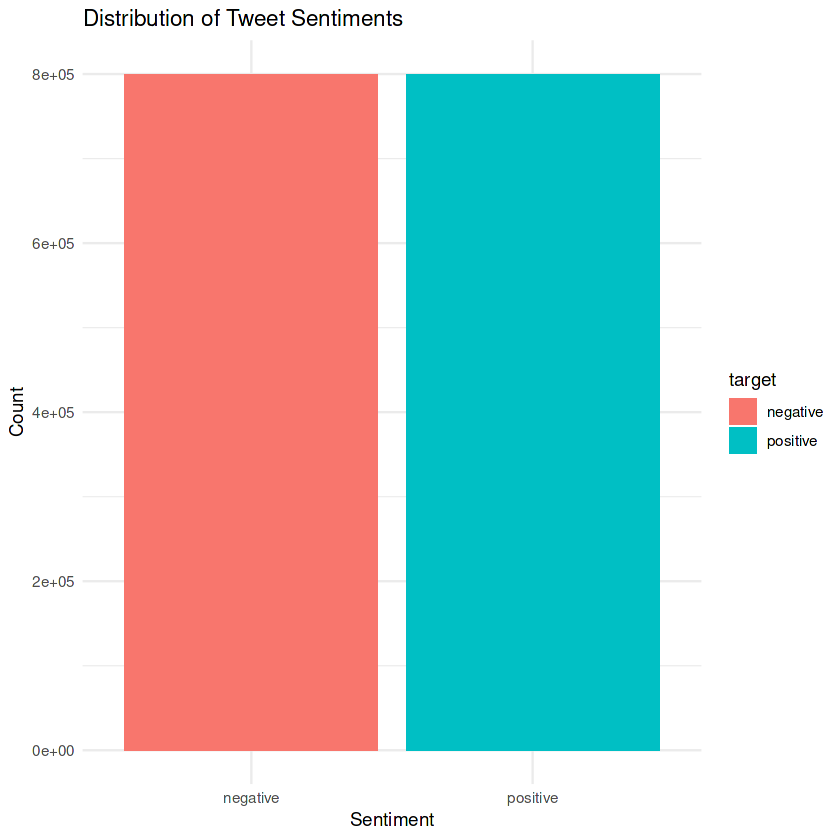

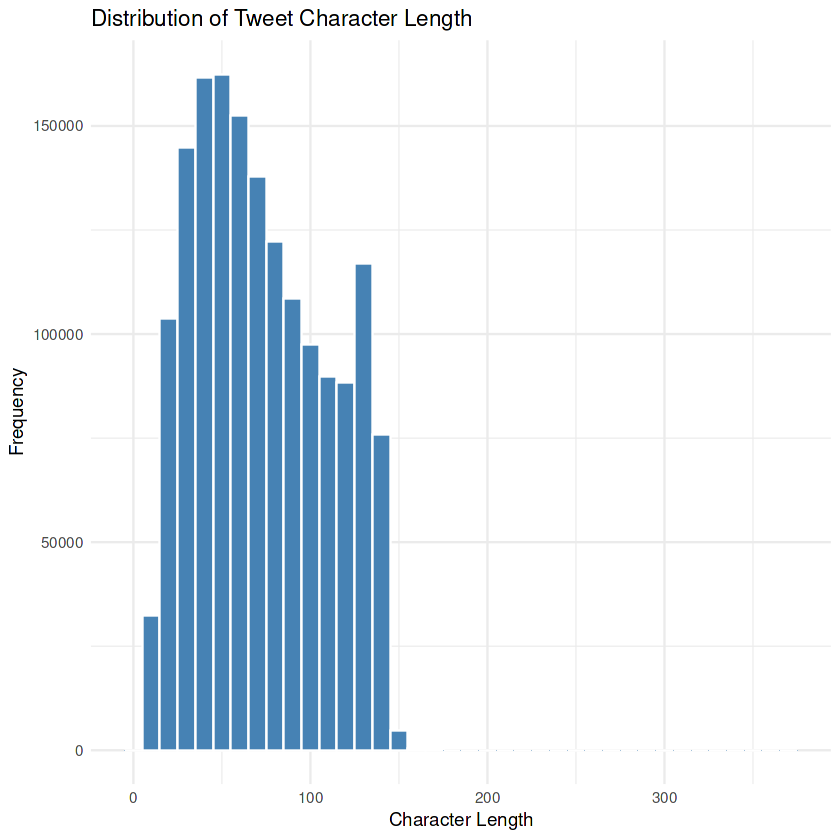

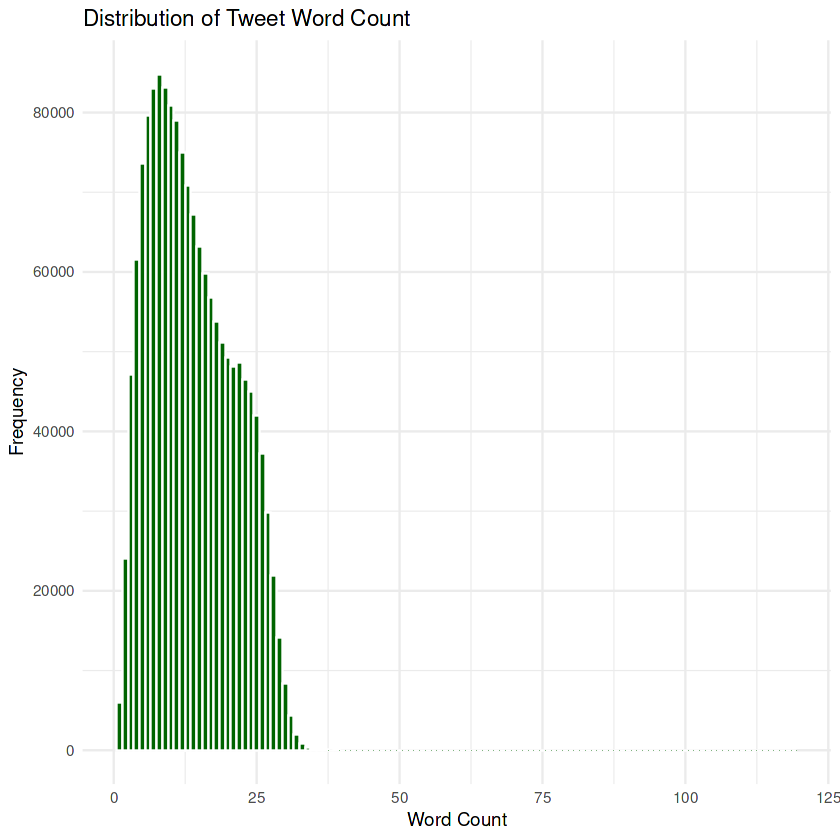

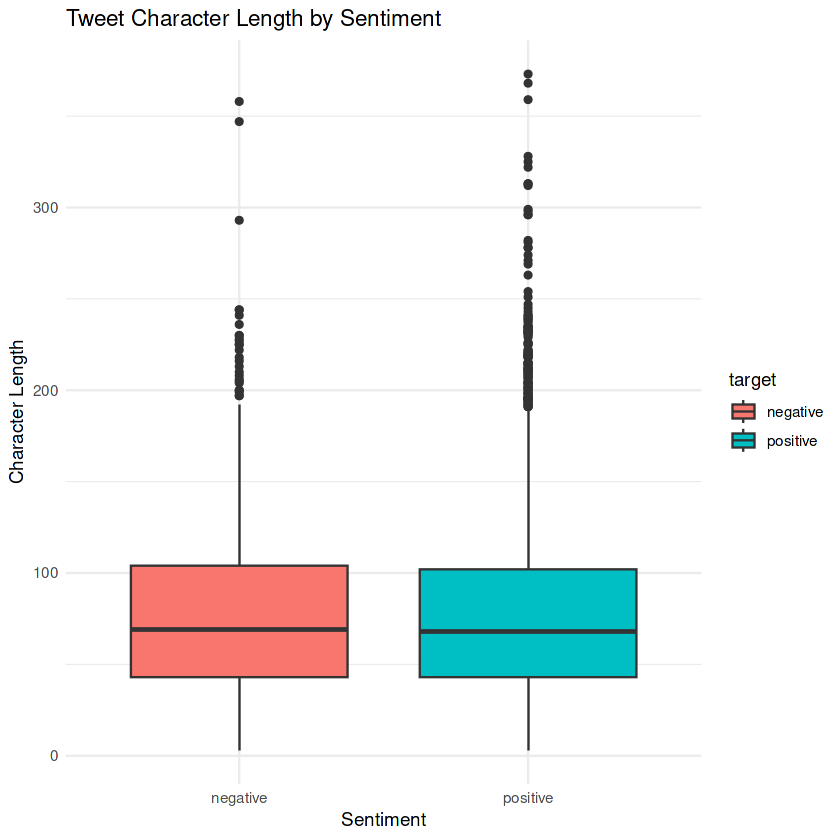

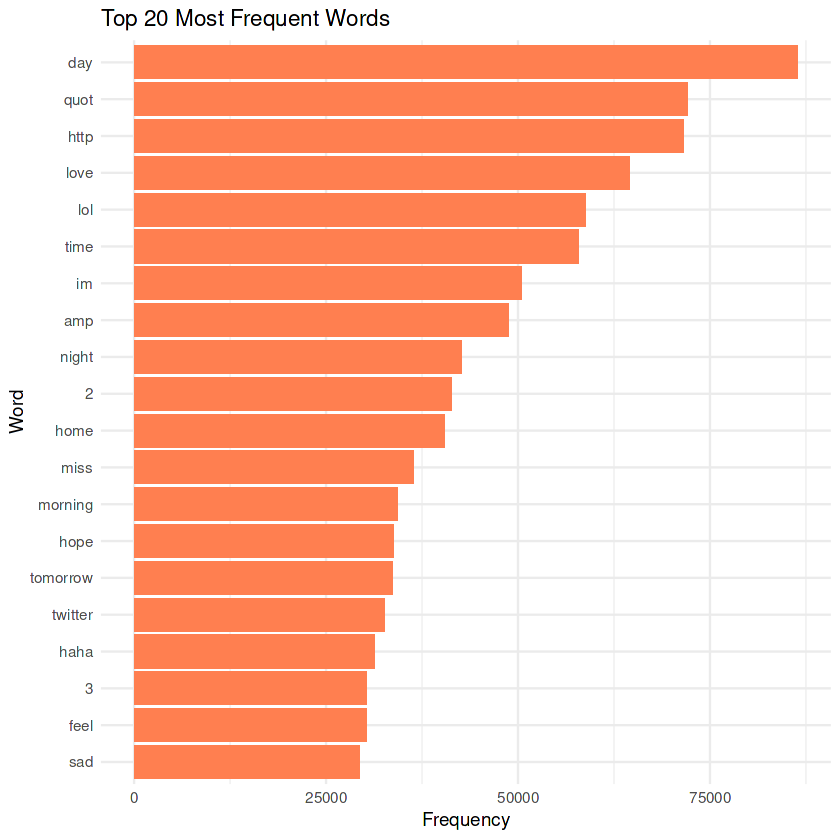

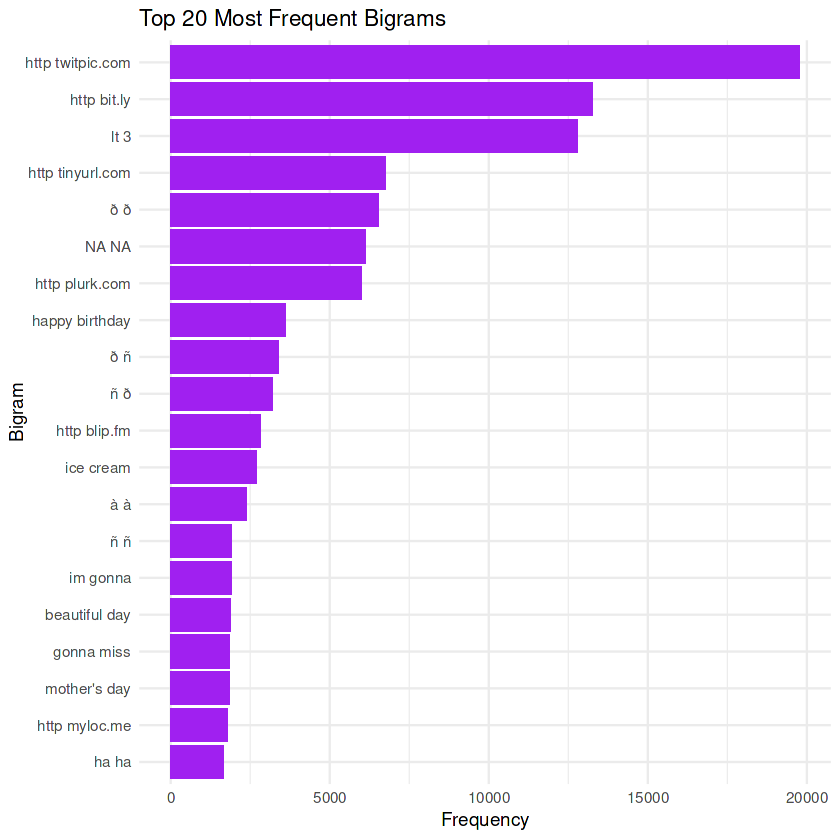

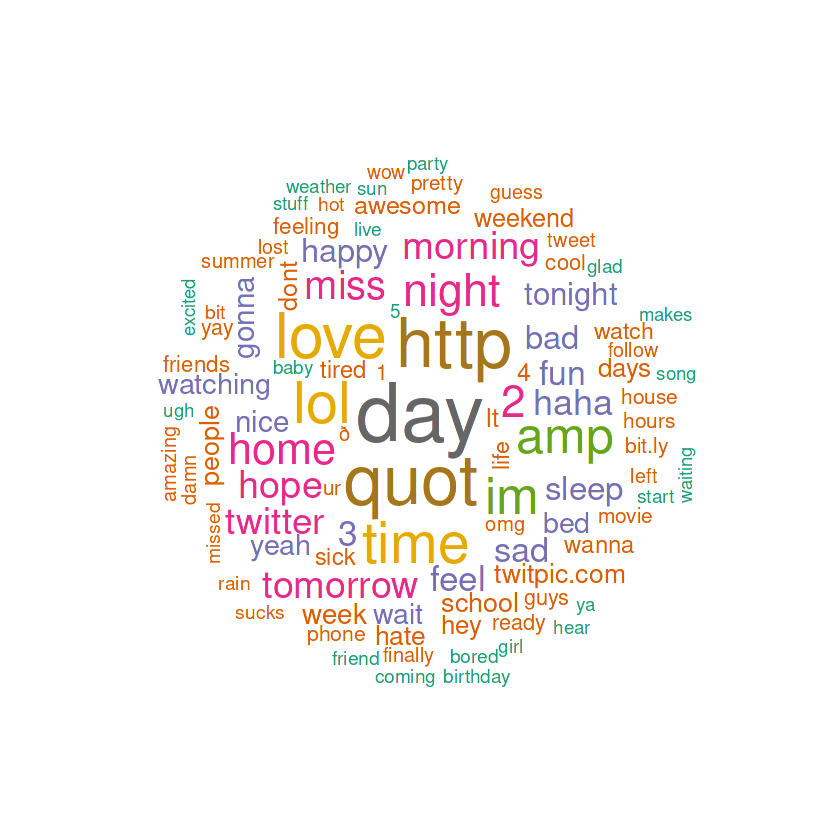

In [4]:
p1 <- ggplot(tweets_clean, aes(x = target, fill = target)) +
  geom_bar() +
  labs(title = "Distribution of Tweet Sentiments", x = "Sentiment", y = "Count") +
  theme_minimal()
print(p1)

p2 <- ggplot(tweets_clean, aes(x = char_length)) +
  geom_histogram(binwidth = 10, fill = "steelblue", color = "white") +
  labs(title = "Distribution of Tweet Character Length", x = "Character Length", y = "Frequency") +
  theme_minimal()
print(p2)

p3 <- ggplot(tweets_clean, aes(x = word_count)) +
  geom_histogram(binwidth = 1, fill = "darkgreen", color = "white") +
  labs(title = "Distribution of Tweet Word Count", x = "Word Count", y = "Frequency") +
  theme_minimal()
print(p3)


tweets_words <- tweets_clean %>%
  unnest_tokens(word, text)

data("stop_words")
tweets_words <- tweets_words %>%
  anti_join(stop_words, by = "word")

word_counts <- tweets_words %>% 
  count(word, sort = TRUE)

top20 <- word_counts %>% top_n(20, n)
p5 <- ggplot(top20, aes(x = reorder(word, n), y = n)) +
  geom_bar(stat = "identity", fill = "coral") +
  coord_flip() +
  labs(title = "Top 20 Most Frequent Words", x = "Word", y = "Frequency") +
  theme_minimal()
print(p5)

set.seed(123)  # For reproducibility
wordcloud(words = word_counts$word, freq = word_counts$n, min.freq = 10,
          max.words = 100, random.order = FALSE, colors = brewer.pal(8, "Dark2"))
